<a href="https://colab.research.google.com/github/nivyathiruvoth/Coronavirus-Tweet-Sentiment-Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

###Sentiment analysis studies the subjective information in an expression, that is, the opinions, appraisals, emotions, or attitudes towards a topic, person or entity. Expressions can be classified as positive, negative, or neutral.
###Twitter is one of the most powerful social media platform in the world right now , with 360 million monthly active users and around 500 million tweets sent each day. It is used every day by people to express opinions about different topics, such as products, movies, music, politicians, events, social events, among others.
###Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus. It is a global pandemic that is still infecting millions of people around the world . In this project we will be looking at thousand of tweets made on Covid-19 from around the world and will try to predict the sentiment of each of the tweet by classifying them into three categories positive, negative and neutral.

In [153]:
#Libraries for data manipulation
import pandas as pd
import numpy as np
#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
#Libraries to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [154]:
#Other libraries used
import re
import sys
import requests
from PIL import Image
import requests as r
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

#Now let us mount the drive and load the dataset

In [155]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
#Loading the dataset
tweet_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/Coronavirus Tweet Sentiment Analysis/Coronavirus Tweets.csv',encoding="ISO-8859-1")

In [157]:
#Creating a copy of the dataset
df=tweet_df.copy()

In [158]:
#First look
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [159]:
#Checking basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [160]:
#Checking the shape of the dataset
print("The dataset contains",df.shape[0],"rows")
print("The dataset contains",df.shape[1],"columns")

The dataset contains 41157 rows
The dataset contains 6 columns


In [161]:
#Checking for duplicates
print("The number of duplicates are:",len(df[df.duplicated()]))

The number of duplicates are: 0


In [162]:
#Getting count of null values in all the columns
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

###We can observe that only the column 'Location' contains null values. But we are not considering that column for sentiment analysis. Hence there is no need for null value treatment.


##Let's create a word cloud showing the different variables in the given dataset.

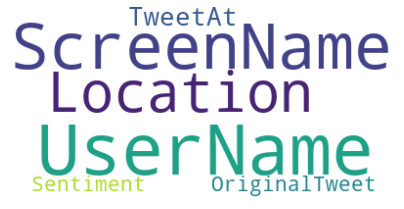

In [163]:
#Storing the column names to make a word cloud
plt.rcParams['figure.figsize']=7,7
text1 = " ".join(title for title in df.columns)
# Creating word_cloud with text as argument in .generate() method
word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text1)
# Display the generated Word Cloud
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [164]:
#Unique number of values in each column
df.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

###It is clear that screenName and UserName are unique for each observation in the given dataset. Therefore we will remove them.

In [165]:
#Drop UserName and ScreenName
df.drop(["UserName","ScreenName"],axis=1,inplace=True)

#**Target variable analysis**

###Now, let's analyze the target variable, **Sentiment**

In [166]:
#Checking subcategories of target variable
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

###We ave 5 subcategories for Sentiment, and they are 'Neutral', 'Positive', 'Extremely Negative', 'Negative' and 'Extremely Positive'

In [167]:
#Analysing the number of tweets in each subcategory of target variable
df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Text(0, 0.5, 'Number of tweets')

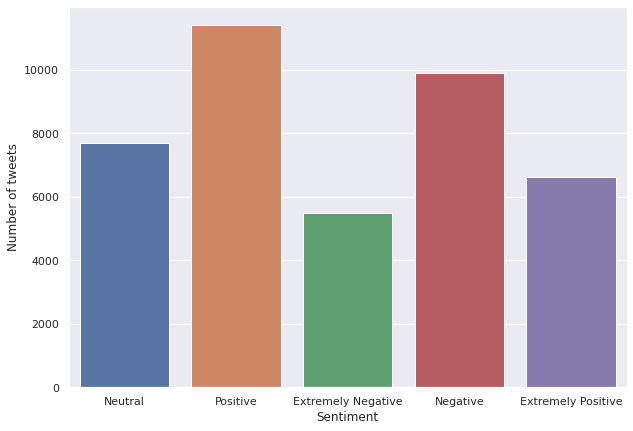

In [168]:
#Setting the heigt and width of the graph
plt.rcParams["figure.figsize"]=10,7
#Plotting the total number of tweets for each subcategory in the target variable
sns.countplot(x="Sentiment", data=df)
plt.ylabel("Number of tweets")

#Converting Sentiment 

###We will convert this 5-class classification problem into a 3-class classification problem by merging Extremely Positive tweets with positive tweets and Extremely Negative tweets with negative tweets.

In [169]:
def Sentiment_Grouping(sentiment):

  '''This function will combiner Extremely Positive tweets with Positive Category
     and Extremely Negative tweets with Negative Category'''

  if sentiment == "Extremely Positive":
    return "Positive"
  elif sentiment == "Extremely Negative":
    return "Negative"
  else:
    return sentiment

In [170]:
#Apply the Sentiment_Grouping function on the Sentiment column
df["Sentiment"] = df["Sentiment"].apply(Sentiment_Grouping)

In [171]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

###The types of sentiments after grouping are:

###1.Neutral
###2.Positive
###3.Negative

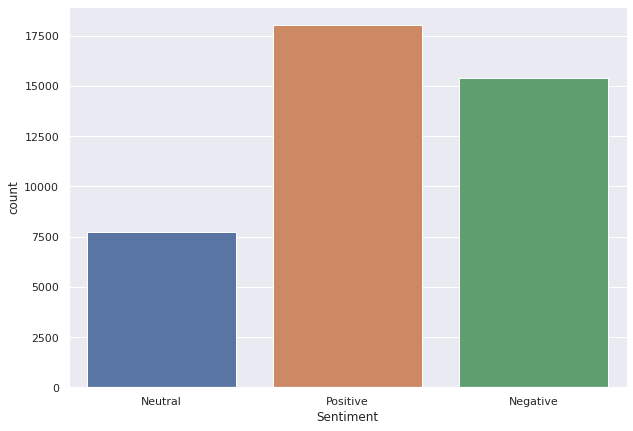

In [172]:
#Plotting the total number of tweets for each subcategory in the target variable after the transformation
plt.rcParams["figure.figsize"]=10,7
sns.countplot(x="Sentiment", data=df)

#Location Analysis

###Let us find out top 10 locations of tweet

In [173]:
#Getting total number of tweets tweeted from all the locations
loc=df['Location'].value_counts().reset_index()
loc.rename(columns={'index':"location","Location":"count"},inplace=True)
loc

,location,count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
...,...,...
12215,Staffordshire Moorlands,1
12216,Kithchener ON,1
12217,"Tulsa, Ok",1
12218,"Watford, South Oxhey, Bushey",1


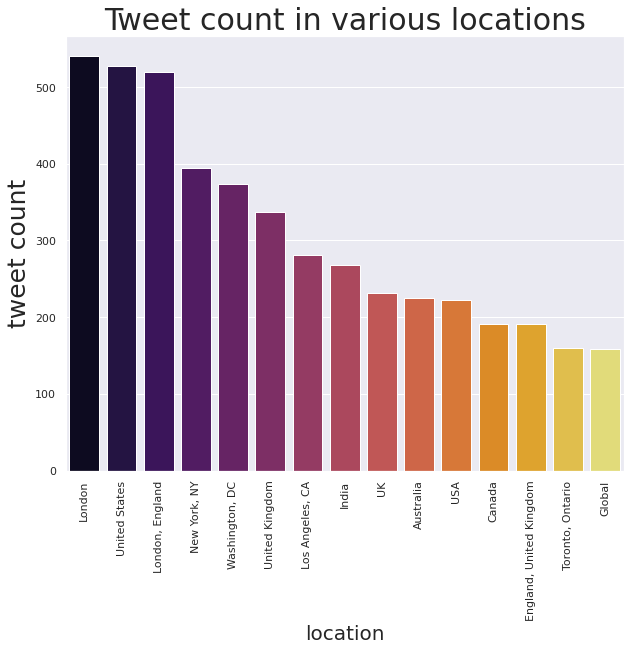

In [174]:
#Plotting number of tweets v/s location
plt.rcParams["figure.figsize"]=(10,8)
sns.barplot(loc["location"][0:15], x = 'location', y =loc["count"][0:15], palette ='inferno').tick_params(axis='x', rotation=90)
plt.title('Tweet count in various locations', fontsize = 30)
plt.xlabel('location', fontsize = 20)
plt.ylabel('tweet count', fontsize = 25)
plt.show()

###Most of the tweets are from United States, London and New York.

#Date Analysis

In [175]:
#Converting the TweetAt column to a datetime object
df["TweetAt"] = pd.to_datetime(df["TweetAt"])

In [176]:
#Obtaining the time period of the dataset 
print("Our dataset contains tweets from {}th {} {} to {}th {} {}".format(df["TweetAt"].min().day, df["TweetAt"].min().month_name(), df["TweetAt"].min().year,
         df["TweetAt"].max().day, df["TweetAt"].max().month_name(), df["TweetAt"].max().year))

Our dataset contains tweets from 4th January 2020 to 4th December 2020


##Extract day, month and day name

In [177]:
#Creating new column for day and month from date colum "TweetAt"
df['day'] = pd.DatetimeIndex(df['TweetAt']).day
df['month'] = pd.DatetimeIndex(df['TweetAt']).month
#Creating a column containing name of the weekday
df["week day"]=pd.DatetimeIndex(df['TweetAt']).day_name()

In [178]:
#Obtaining the bottom 5 rows of the dataset
df.tail()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day
41152,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,14,4,Tuesday
41153,NaN,2020-04-14,Response to complaint not provided citing COVI...,Negative,14,4,Tuesday
41154,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive,14,4,Tuesday
41155,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,14,4,Tuesday
41156,i love you so much || he/him,2020-04-14,@TartiiCat Well new/used Rift S are going for ...,Negative,14,4,Tuesday


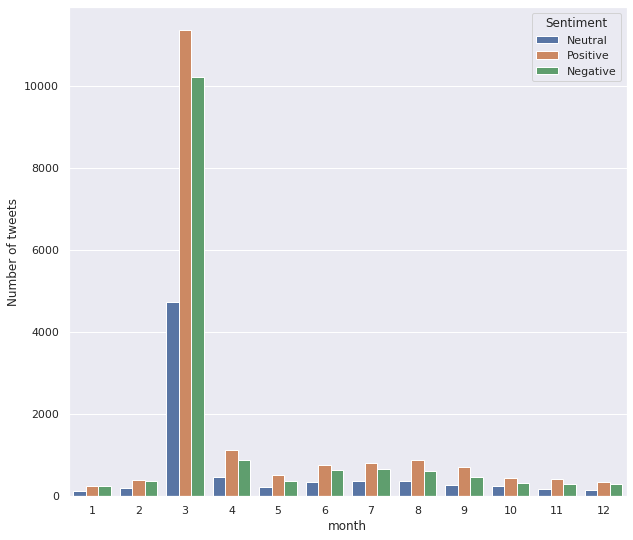

In [179]:
#Plotting total number of tweets for each sentiment over the months
plt.rcParams["figure.figsize"]=(10,9)
ax = sns.countplot(x="month", hue="Sentiment", data=df)
plt.ylabel("Number of tweets")
plt.show()

###It is clear the most number of tweets was created in the month of March.
###Let's analyze the tweet count on a daily basis in the month of March

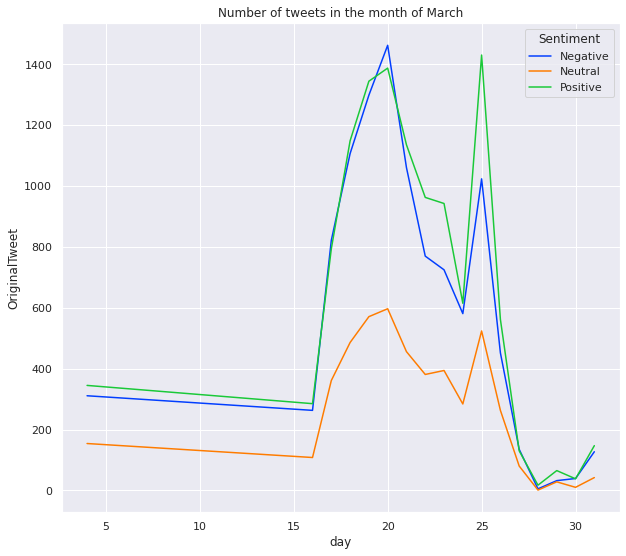

In [180]:
#Creating a subset of our dataframe that will only contains tweets from the month of march
day_analysis = df[df["month"] == 3].copy()
#Grouping our dataset on the basis of Day and sentiment to get the number of tweets tweeted on each day in the month of march belonging to each sentiment
daySentiment_groupby = day_analysis.groupby(["day" , "Sentiment"]).agg({ "OriginalTweet" : "count"}).reset_index()
sns.lineplot(x = "day" , y ="OriginalTweet" , hue="Sentiment" ,  data = daySentiment_groupby , palette = 'bright' )
plt.title("Number of tweets in the month of March")
plt.show()

###Let's check out the day when people tweet the most.

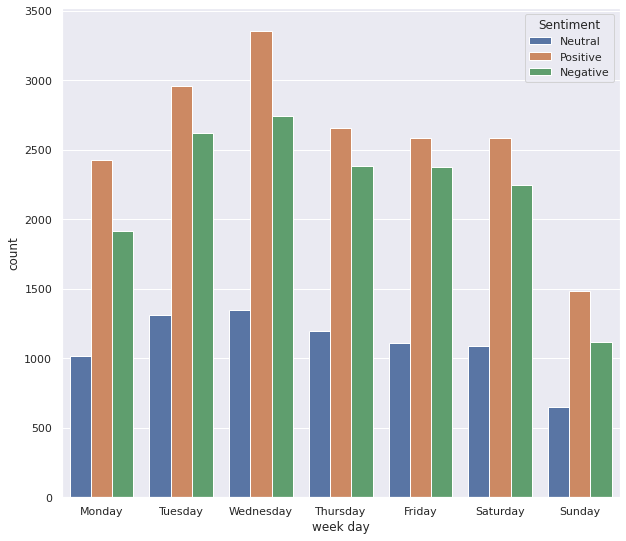

In [181]:
#Checking which day people are creating more tweets
ax = sns.countplot(x="week day", hue="Sentiment", data=df)

###We expected it to be the holiday that people tweet the most. But on Wednesday it was found that people were tweeting more. This may be the result of lockdown.

#Tweet length analysis

###Lets us try to get insights regarding tweet length.

In [182]:
#Creating a new column 'length' by calculating the length of tweets
df['length']=df['OriginalTweet'].apply(len)
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310


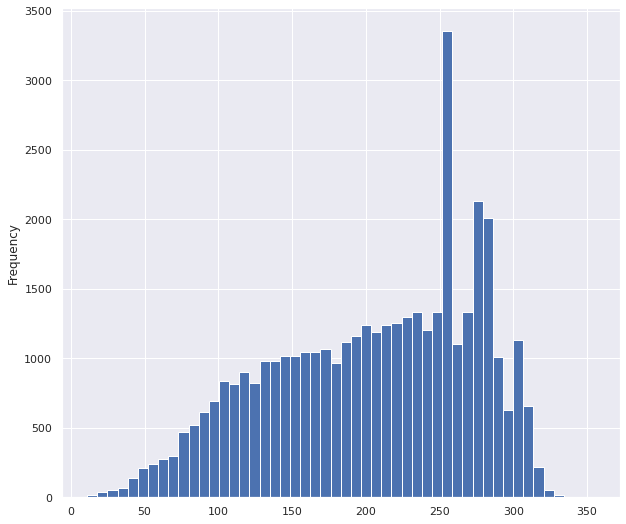

In [183]:
#Checking distribution of length of tweets
df['length'].plot(bins=50,kind='hist')

In [184]:
def show_dist(df, col):

  '''Function is to show distribution of any particular column for each of the different sentiment'''

  bins = np.arange(df[col].min(), df[col].max() + 1)
  g = sns.FacetGrid(df, col='Sentiment', height=5, hue='Sentiment', palette="bright")
  g = g.map(sns.histplot, col, kde=False, bins=bins)

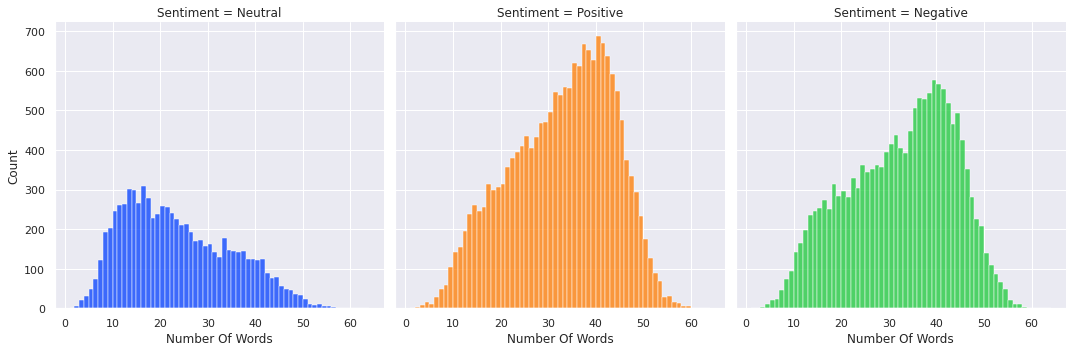

In [185]:
#Creating a new column named "Number Of Words" to store the number of words in each tweet
df["Number Of Words"] = df["OriginalTweet"].str.split().apply(len)

show_dist(df , 'Number Of Words')

###The number of words present in tweets of neutral sentiment is far less when compared to tweets with a positive or negative sentiment . Most of the positive and negative sentiment tweets contain almost 40 words on average.

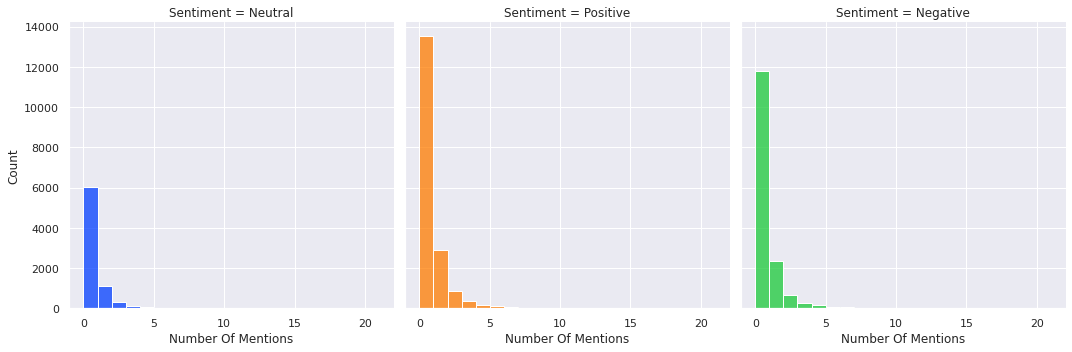

In [186]:
#Creating a new column named "Number Of Mentions" to store the number of mentions in each tweet
df["Number Of Mentions"] = df["OriginalTweet"].apply(lambda tweet : len(re.findall(r'@[^\s]+', tweet)))

show_dist(df, "Number Of Mentions")

###Most of the tweets contain no mention and there is no particular relationship between number of mentions and regard the sentiment

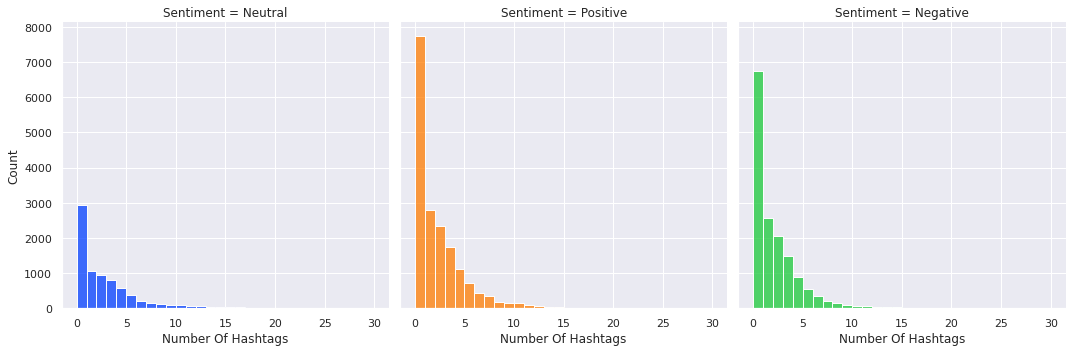

In [187]:
#Creating a new columns named "Number Of Hashtags" to store the number of hastags in each tweet
df["Number Of Hashtags"] = df["OriginalTweet"].apply(lambda tweet : len(re.findall(r'#[^\s]+', tweet)))

show_dist(df, "Number Of Hashtags")

###Most tweets do not have a hashtag. Again, the number of hashtags has nothing to do with the sentiment.

#Extract hashtags

###Let's now try to understand the impact of hashtags on tweets sentiment

In [188]:
def extract_hash_tags(s):
  return [part[1:] for part in s.split() if part.startswith('#')]
df['hashtags']=df['OriginalTweet'].apply(extract_hash_tags)

In [189]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111,8,3,0,[]
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237,38,0,0,[]
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131,14,0,0,[]
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306,42,0,7,"[COVID19france, COVID_19, COVID19, coronavirus..."
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310,40,0,6,"[COVID19, coronavirus, CoronavirusFrance, rest..."


In [190]:
#Creating a new dataframe containing hashtags and their count
d = Counter(df.hashtags.sum())
hashtags= pd.DataFrame([d]).T

In [191]:
#Renaming the columns and resetting the index
hashtags.rename_axis('hashtag',inplace=True)
hashtags.rename(columns={0:"Count"},inplace=True)
hashtags=hashtags.reset_index()

In [192]:
#Sorting the hashtags based on their count
hashtags.sort_values(by='Count',ascending=False,inplace=True)

In [193]:
#Checking the dataframe
hashtags

,hashtag,Count
3,coronavirus,12224
2,COVID19,3204
10,Covid_19,2469
53,Coronavirus,2068
26,COVID2019,1588
...,...,...
8504,WhoDidThis,1
8505,expensive,1
8507,PTCares,1
8508,vlogger,1


In [194]:
#Creating a pie plot to show the top 10 hashtag and their relative percentage share among themselves
data = {
   "values": hashtags['Count'][:10],
   "labels": hashtags["hashtag"][:10],
   "domain": {"column": 0},
   "name": "hashtags",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
#Providing title for the plot
layout = go.Layout(title="<b>Relative Percentage of top 10 Hashtag</b>", legend=dict(x=0.9, y=0.8, orientation="v"))
#Ploting
data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

###"Coronavirus" is the most used hashtag.
###Let's create a word cloud to visualize the hashtags

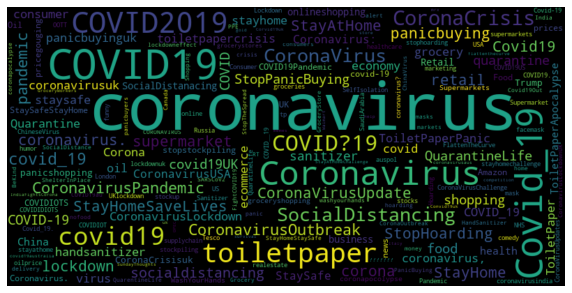

In [195]:
#Creating a dictionary containing hash tag and it's count
data = dict(zip(hashtags['hashtag'].tolist(), hashtags['Count'].tolist()))
#Generate word cloud of hash tags based on their frequency
wc = WordCloud(width=800, height=400, max_words=200,background_color = 'black').generate_from_frequencies(data)
#Providing figure size
plt.figure(figsize=(10, 10))
#plotting
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [196]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111,8,3,0,[]
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237,38,0,0,[]
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131,14,0,0,[]
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306,42,0,7,"[COVID19france, COVID_19, COVID19, coronavirus..."
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310,40,0,6,"[COVID19, coronavirus, CoronavirusFrance, rest..."


In [197]:
#Creating subsets of the dataframe based on sentiment category Positive, Negative and Neutral
Positive_tweet = df[df["Sentiment"] == "Positive"]
Negative_tweet = df[df["Sentiment"] == "Negative"]
Neutral_tweet = df[df["Sentiment"] == "Neutral"]

In [198]:
def hashtag_freq_graph(df):
  '''This function gives the frequency bar graph of the hashtags'''
  #Extracting hashtags from tweets
  df['hashtag'] = df['OriginalTweet'].apply(lambda twt : re.findall(r"#(\w+)", twt))
  #Taking value count on hashtags
  hashtags=df.OriginalTweet.str.extractall(r'(\#\w+)')[0].value_counts().reset_index()
  #renaming the columns
  hashtags.rename(columns={'index':"hashtag",0:'freq'},inplace=True)

  #Keeping only 15  most frequently used hashtags 
  hashtags=hashtags[:15]
  #Seting figuresize
  sns.set(rc = {'figure.figsize':(15,8)})
  #Ploting frequency against hashtag
  sns.barplot(x="hashtag" , y ="freq" , data = hashtags , palette = "bright")
  plt.xticks(rotation=45)
  plt.show()

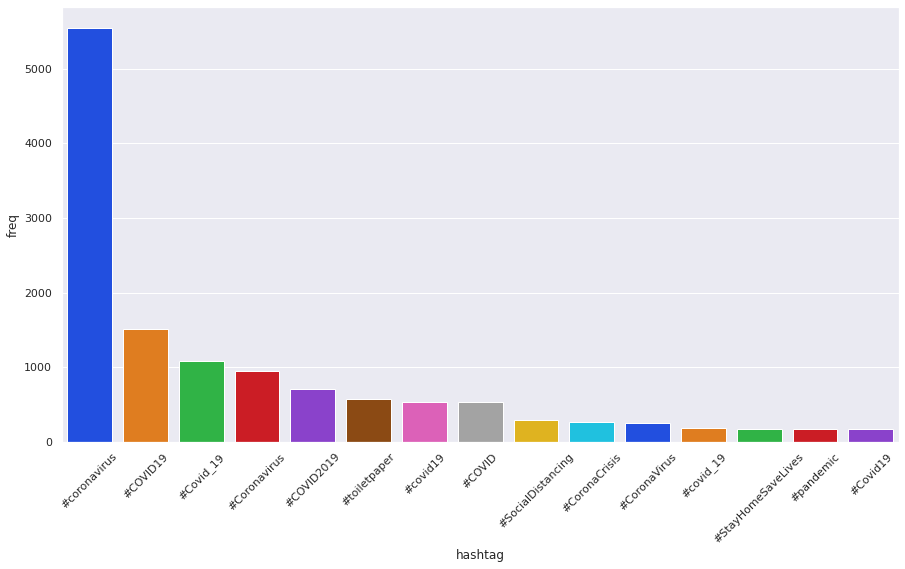

In [199]:
#Calling hashtag_freq_graph on positive tweet dataframe
hashtag_freq_graph(Positive_tweet)

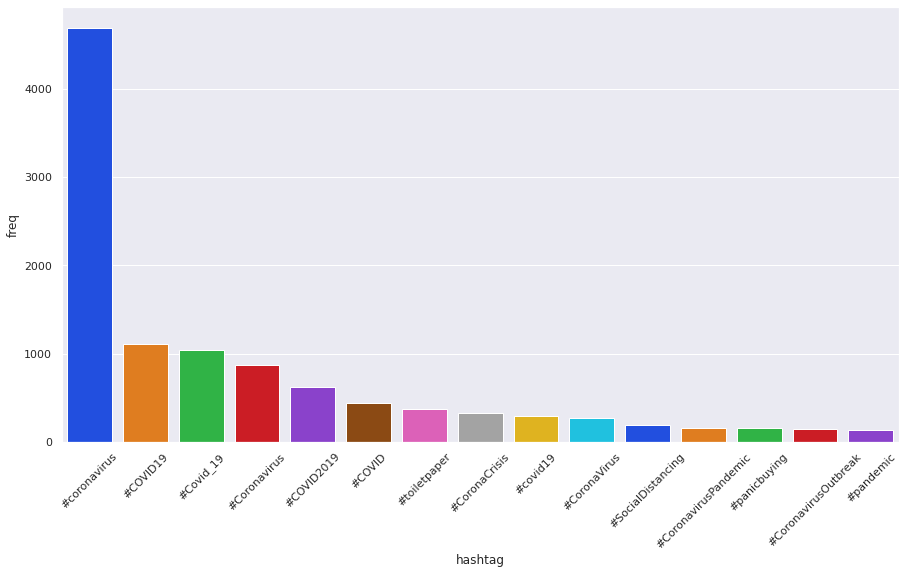

In [200]:
#Calling hashtag_freq_graph on negative tweet dataframe
hashtag_freq_graph(Negative_tweet)

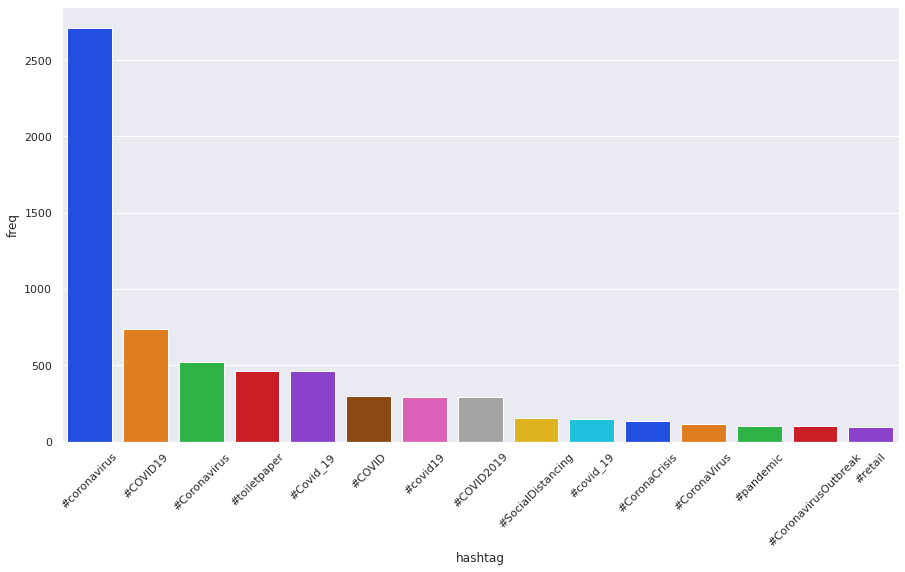

In [201]:
#Calling hashtag_freq_graph on neutral tweet dataframe
hashtag_freq_graph(Neutral_tweet)

####By looking at the bar graphs for positive and negative sentiment we can conclude that the hastags like #StayHomesaveLives are much more used in tweets of positive sentiment as compared to the negative sentiment tweets on the other hand hashtags like #panicbuying are more frequently used in negative sentiment tweets.

#**Tokenization**

###Tokenization is the term used to describe the process of converting the normal text strings in to a list of tokens.


##Tweet cleaning

###Remove user name, links, symbols, spam and numbers

In [202]:
#Importing Libraries for NLP
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

#Remove user name, links, symbols, spam and numbers

In [203]:
def clean_tweets(tweet):
    #Removes usernames
    tweet = re.sub('@[^\s]+','',tweet)
    #Removes links
    tweet = re.sub('http[^\s]+','',tweet)
    #Removes numbers
    tweet = re.sub(r'\d+','',tweet)
    #Removes special characters
    tweet = re.sub('[^a-zA-Z0-9\s]+','',tweet)
    return tweet

df['cleaned tweet'] = df['OriginalTweet'].apply(clean_tweets)

In [204]:
#Installing contractions  
!pip install contractions
!{sys.executable} -m pip install contractions
import contractions

In [205]:
def contractions_remover(text):
  '''Tis function fixes contractions'''
# creating an empty list
  expanded_words = []    
  for word in text.split():
    # using contractions.fix to expand the shotened words
    expanded_words.append(contractions.fix(word))   
  #joining words    
  expanded_text = ' '.join(expanded_words)
  return expanded_text
#Applying the function contraction remover on the column cleaned tweet
df["cleaned tweet"] = df["cleaned tweet"].apply(contractions_remover)

#Remove pnctuation and stopwords

####Stopwords are those commonly used words that are often added to sentences to make them grammatically correct.They do not add any values to our analysis as these words carry less or no meaning as far as churning out information about the sentiment is concerned.

In [207]:
#Downloading stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [208]:
#Stpring the set of stopwords in Enlish
stop_words = set(stopwords.words('english'))
print("The stop words in Englis are",stop_words)
#Creating a whitelist of stopwords we need to keep as they affect the sentiment
whitelist = ["n't", "not", "no" , "nor" , "couldn't" , "wouldn't" ,"isn't" , "haven't" , "wasn't" , "didn't" , "hasn't" , "shouldn't" , "doesn't" , "weren't" ,
              "aren't"]
#Creating a list of stopwords which doesnot contain our whitelist              
stops=[item for item in stop_words if item not in whitelist]
print("The required stopwords are",stops)

The stop words in Englis are {"haven't", 'how', "don't", 'what', 'so', 'off', "shouldn't", 'wasn', 'at', 'those', 'some', 'him', 'being', 'about', 'but', 'on', 'doesn', "wasn't", 'not', 'any', 'you', 're', 'the', "isn't", 'mustn', 'weren', 'himself', 'why', "she's", 'to', 'shouldn', "hasn't", "hadn't", 'our', 'them', 'theirs', 'under', 'all', 'who', 'there', "you're", 'own', 'now', 'than', "shan't", 'too', 's', "you'd", 'with', "mightn't", 'each', 'me', 'mightn', 'as', "you've", "aren't", 'your', 'he', 'which', "wouldn't", 'd', 'hers', 'should', 'had', 'doing', 'is', 'for', 'in', 'his', 'was', 'where', 'shan', 'down', 'didn', 'we', 'am', 'above', 'once', 'myself', 'again', 'will', 'my', 'out', 'few', 'by', 'other', 'of', 'more', 't', "mustn't", 'have', 'whom', "weren't", 'ain', 'most', 'it', 'yours', 'they', 'and', 'same', 'been', 'needn', 'did', 'while', 'from', 'both', 'just', 'll', 'before', 'because', 'through', 'are', 'if', 'over', 'nor', 'hasn', "doesn't", "you'll", 'here', 'that

In [209]:
def text_process(msg):
    '''This function removes punctuations and stopwords from sentences'''
    #Storing characters other than punctuations from sentences
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    #Creating a list of all the words that are not stopwords or are present in whitelist and then joining them to return a sentence
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in stops])

In [210]:
#Applying the function text_process on the column cleaned tweet
df['cleaned tweet'] = df['cleaned tweet'].apply(text_process)

In [212]:
df.tail()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags,cleaned tweet
41152,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,14,4,Tuesday,102,12,0,2,"[NZ, COVID-19]",airline pilots offering stock supermarket shel...
41153,NaN,2020-04-14,Response to complaint not provided citing COVI...,Negative,14,4,Tuesday,138,23,0,0,[],response complaint not provided citing covid r...
41154,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive,14,4,Tuesday,136,18,2,2,"[coronavirus, toiletpaper]",know getting tough rationing toilet paper coro...
41155,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,14,4,Tuesday,111,18,0,3,"[coronavirus, COVID19, coronavirus]",wrong smell hand sanitizer starting turn coron...
41156,i love you so much || he/him,2020-04-14,@TartiiCat Well new/used Rift S are going for ...,Negative,14,4,Tuesday,255,46,1,0,[],well newused rift going amazon rn although nor...
